In [34]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.ticker import FuncFormatter
from typing import List, Set

In [35]:
pd.set_option('display.max_rows', 20)
warnings.filterwarnings('ignore')

### Чтение и оптимизация датасетов

In [3]:
questions: pd.DataFrame = pd.read_csv("questions.csv")
lectures: pd.DataFrame = pd.read_csv("lectures.csv")
train: pd.DataFrame = pd.read_csv("train.csv")

In [4]:
train['prior_question_had_explanation'] = train['prior_question_had_explanation'].astype('boolean')
train['user_id']=train['user_id'].astype('int32')
train['content_id']=train['content_id'].astype('int16')
train['content_type_id']=train['content_type_id'].astype('boolean')
train['task_container_id']=train['task_container_id'].astype('int16')
train['user_answer']=train['user_answer'].astype('int8')
train['answered_correctly']=train['answered_correctly'].astype('int8')
train['prior_question_elapsed_time']=train['prior_question_elapsed_time'].astype('float32')
train['prior_question_elapsed_time']=train['prior_question_elapsed_time'].astype('float32')
train

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,False,1,3,1,NaN,<NA>
1,1,56943,115,5716,False,2,2,1,37000.0,False
2,2,118363,115,128,False,0,0,1,55000.0,False
3,3,131167,115,7860,False,3,0,1,19000.0,False
4,4,137965,115,7922,False,4,1,1,11000.0,False
...,...,...,...,...,...,...,...,...,...,...
101230327,101230327,428564420,2147482888,3586,False,22,0,1,18000.0,True
101230328,101230328,428585000,2147482888,6341,False,23,3,1,14000.0,True
101230329,101230329,428613475,2147482888,4212,False,24,3,1,14000.0,True
101230330,101230330,428649406,2147482888,6343,False,25,1,0,22000.0,True


In [5]:
questions['tags'] = questions['tags'].astype(str)
questions

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38
...,...,...,...,...,...
13518,13518,13518,3,5,14
13519,13519,13519,3,5,8
13520,13520,13520,2,5,73
13521,13521,13521,0,5,125


In [6]:
lectures

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question
...,...,...,...,...
413,32535,8,5,solving question
414,32570,113,3,solving question
415,32604,24,6,concept
416,32625,142,2,concept


## Расчет метрик

### Анализ поведения пользователей

In [7]:
print(f"Unique users: {train['user_id'].nunique()}")

Unique users: 393656


In [8]:
print(f"Unique content: {train['content_id'].nunique()}") 

Unique content: 13782


In [9]:
print(f"Unique questions :{train[train.content_type_id == False]['content_id'].nunique()}")

Unique questions :13523


##### False - был задан вопрос, True - лекция просмотрена.

In [10]:
train.content_type_id.value_counts()

False    99271300
True      1959032
Name: content_type_id, dtype: Int64

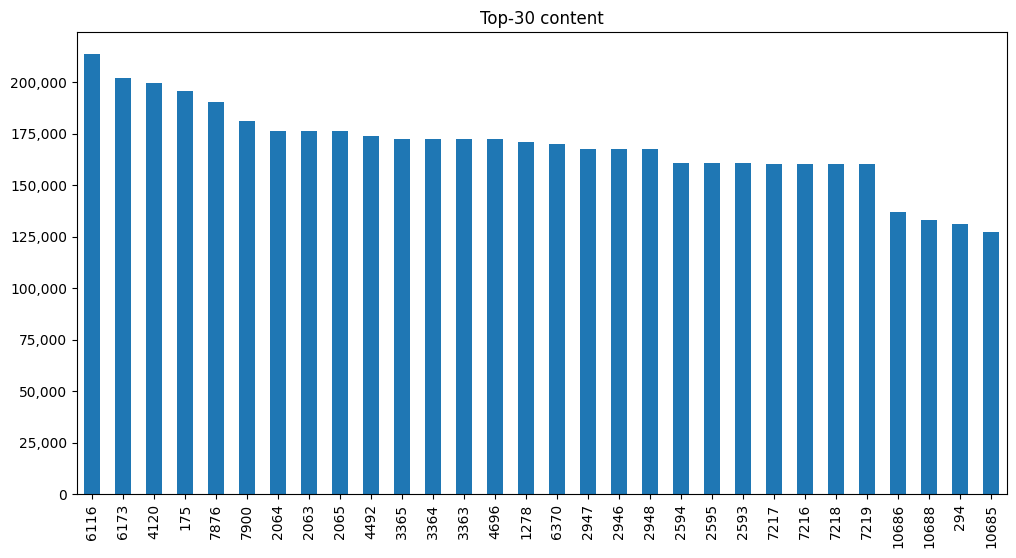

In [36]:
cids: List[int] = train['content_id'].value_counts()[:30]

fig = plt.figure(figsize=(12,6))
ax = cids.plot.bar()
plt.title("Top-30 content")
plt.xticks(rotation=90)
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

In [12]:
print(f"Unique tasks: {train['task_container_id'].nunique()}")

Unique tasks: 10000


#### Распределение ответов пользователей

In [13]:
train["user_answer"].value_counts()

 0    28186489
 1    26990007
 3    26084784
 2    18010020
-1     1959032
Name: user_answer, dtype: int64

#### Затраченное на ответ время

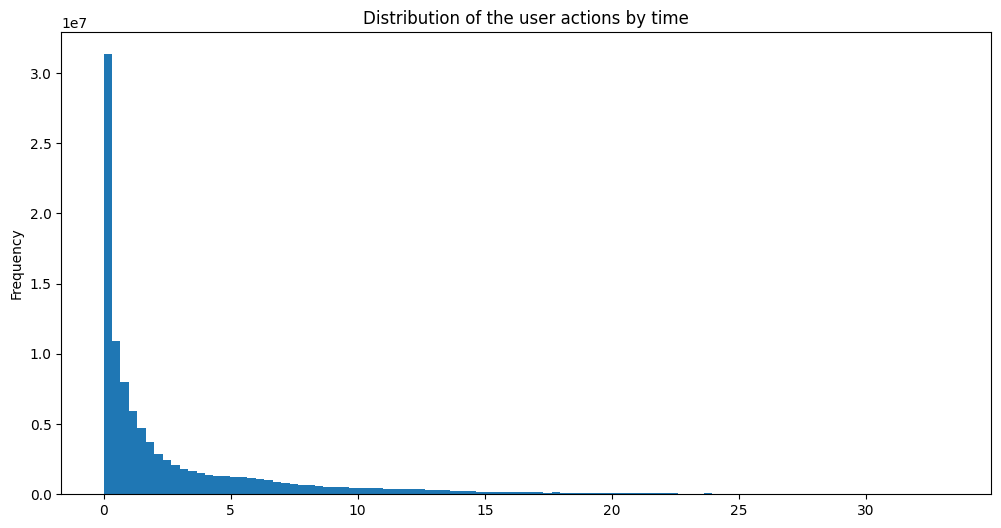

In [14]:
ts: List[float] = train['timestamp']/(31536000000/12)
fig = plt.figure(figsize=(12,6))
ts.plot.hist(bins=100)
plt.title("Distribution of the user actions by time")
plt.xticks(rotation=0)
plt.show()

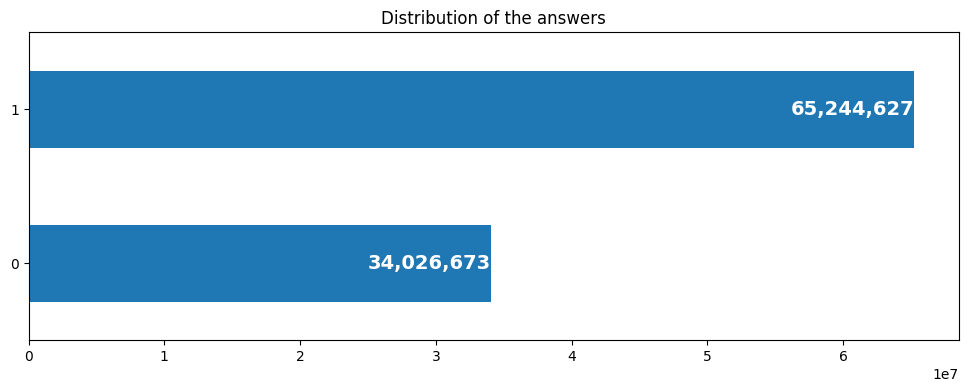

In [15]:
correct: pd.DataFrame = train[train.answered_correctly != -1].answered_correctly.value_counts(ascending=True)
fig = plt.figure(figsize=(12,4))
correct.plot.barh()
for i, v in zip(correct.index, correct.values):
    plt.text(v, i, '{:,}'.format(v), color='white', fontweight='bold', fontsize=14, ha='right', va='center')
plt.title("Distribution of the answers")
plt.xticks(rotation=0)
plt.show()

In [16]:
def fix_column(field: str) -> pd.DataFrame:
    correct: pd.DataFrame = train[train.answered_correctly != -1].groupby([field, 'answered_correctly'], as_index=False).size()
    correct = correct.pivot(index=field, columns='answered_correctly', values='size')
    correct['Percent_correct'] = round(correct.iloc[:,1]/(correct.iloc[:,0] + correct.iloc[:,1]),2)
    correct = correct.sort_values(by = "Percent_correct", ascending = False)
    correct = correct.iloc[:,2]
    return correct

#### Зависимость между количеством корректных ответов и затраченным временем

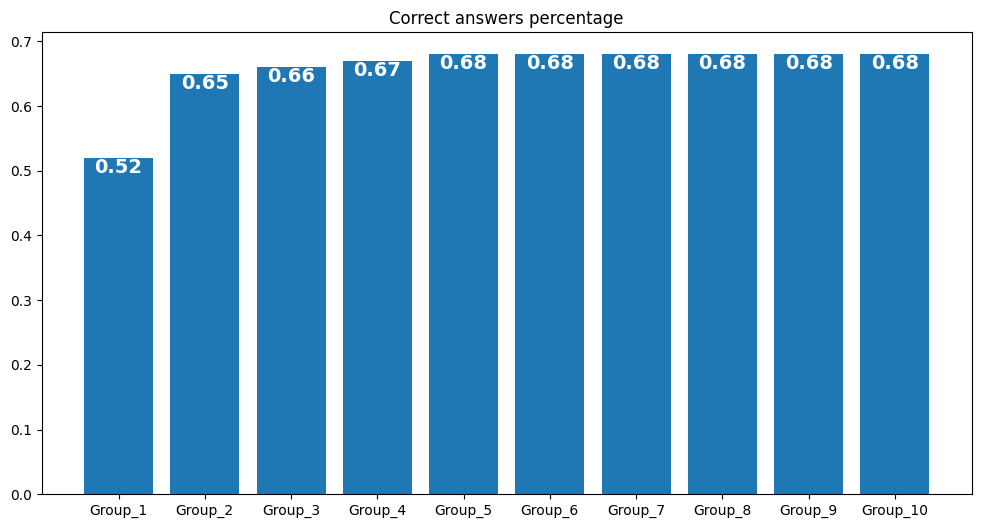

In [17]:
bin_labels_10: List[str] = [f"Group_{i}" for i in range(1, 11)]
train['ts_bin'] = pd.qcut(train['timestamp'], q=10, labels=bin_labels_10)


bins_correct: pd.DataFrame = fix_column("ts_bin")
bins_correct = bins_correct.sort_index()

fig = plt.figure(figsize=(12,6))
plt.bar(bins_correct.index, bins_correct.values)
for i, v in zip(bins_correct.index, bins_correct.values):
    plt.text(i, v, v, color='white', fontweight='bold', fontsize=14, va='top', ha='center')
plt.title("Correct answers percentage")
plt.xticks(rotation=0)
plt.show()

#### Распределение правильных ответов по заданиям

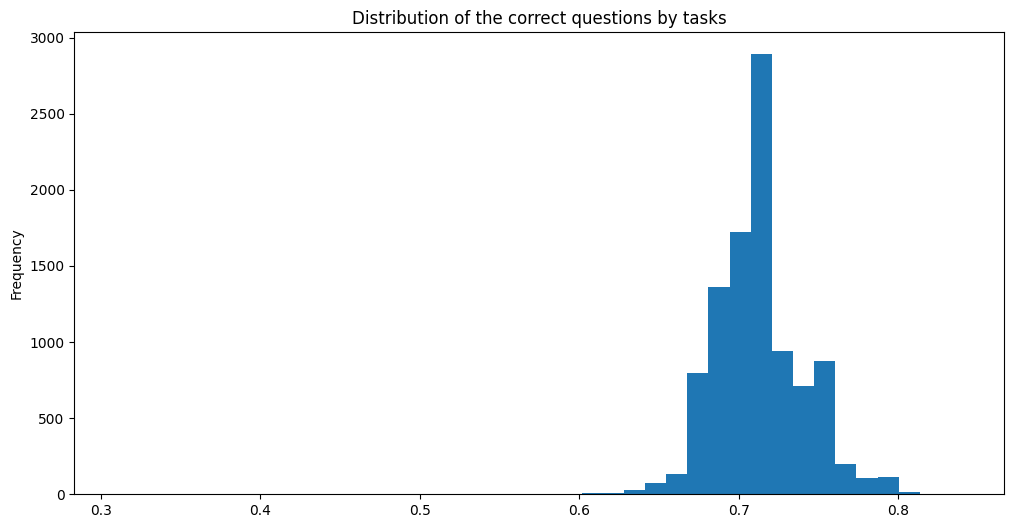

In [18]:
task_id_correct: pd.DataFrame = fix_column("task_container_id")

fig = plt.figure(figsize=(12,6))
task_id_correct.plot.hist(bins=40)
plt.title("Distribution of the correct questions by tasks")
plt.xticks(rotation=0)
plt.show()

#### Анализ лучшего пользователя

In [20]:
user_percent: pd.DataFrame = train[train.answered_correctly != -1].groupby('user_id')['answered_correctly'].agg(Mean='mean', Answers='count')
print(f"Top user by answers: {user_percent[user_percent['Answers'] == user_percent.Answers.max()].index[0]}")

Top user by answers: 801103753


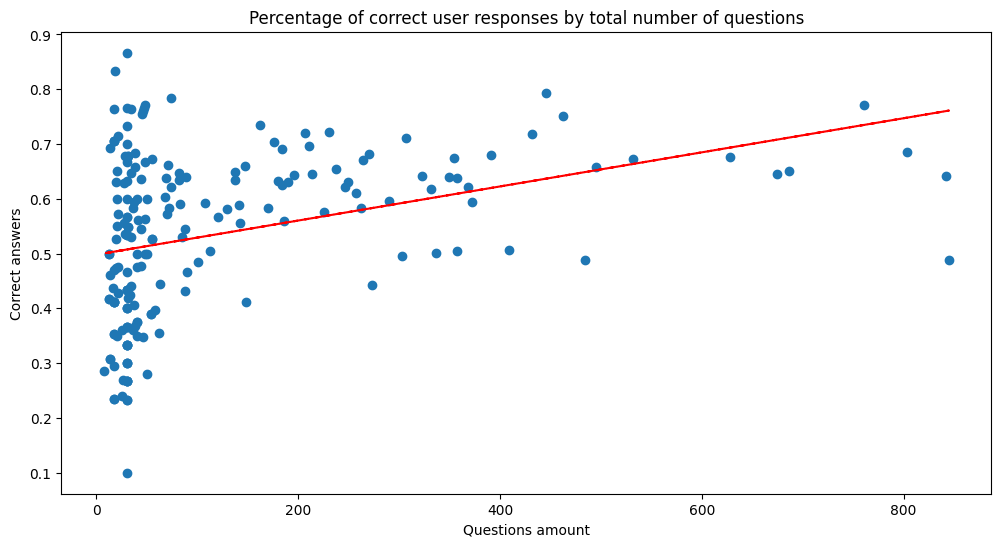

In [21]:
user_percent: pd.DataFrame = user_percent.query('Answers <= 1000').sample(n=200, random_state=1)
x: List[float] = user_percent.Answers
y: List[float] = user_percent.Mean
z: np.array = np.polyfit(x, y, 1)
p: np.array = np.poly1d(z)

fig = plt.figure(figsize=(12,6))
plt.scatter(x, y, marker='o')
plt.title("Percentage of correct user responses by total number of questions")
plt.xticks(rotation=0)
plt.xlabel("Questions amount")
plt.ylabel("Correct answers")
plt.plot(x,p(x),"r--")

plt.show()

### Анализ вопросов

In [22]:
tags: List[str] = [x.split() for x in questions[questions.tags != "nan"].tags.values]
tags: List[str] = [item for elem in tags for item in elem]
tags: Set[str] = set(tags)
print(f"Unique tags: {len(tags)}")

Unique tags: 188


#### Корректность ответов по вопросам

In [23]:
tags_list: List[str] = [x.split() for x in questions.tags.values]
questions['tags'] = tags_list

correct = train[train.answered_correctly != -1].groupby(["content_id", 'answered_correctly'], as_index=False).size()
correct = correct.pivot(index= "content_id", columns='answered_correctly', values='size')
correct.columns = ['Wrong', 'Right']
correct = correct.fillna(0)
correct[['Wrong', 'Right']] = correct[['Wrong', 'Right']].astype(int)
questions = questions.merge(correct, left_on = "question_id", right_on = "content_id", how = "left")
questions

,question_id,bundle_id,correct_answer,part,tags,Wrong,Right
0,0,0,0,1,"[51, 131, 162, 38]",637,6266
1,1,1,1,1,"[131, 36, 81]",809,6589
2,2,2,0,1,"[131, 101, 162, 92]",20015,24890
3,3,3,0,1,"[131, 149, 162, 29]",5067,17906
4,4,4,3,1,"[131, 5, 162, 38]",12275,19461
...,...,...,...,...,...,...,...
13518,13518,13518,3,5,[14],185,683
13519,13519,13519,3,5,[8],396,528
13520,13520,13520,2,5,[73],282,579
13521,13521,13521,0,5,[125],167,703


#### Корректность ответов по тегам

In [37]:
tags_df: pd.DataFrame = pd.DataFrame()
tags: List[str] = list(tags)
for tag in tags:
    df: pd.DataFrame = questions[questions.tags.apply(lambda l: tag in l)]
    df1: pd.DataFrame = df.agg({'Wrong': ['sum'], 'Right': ['sum']})
    df1['Total_questions'] = df1.Wrong + df1.Right
    df1['Question_ids_with_tag'] = len(df)
    df1['tag'] = tag
    df1 = df1.set_index('tag')
    tags_df = tags_df.append(df1)

tags_df[['Wrong', 'Right', 'Total_questions']] = tags_df[['Wrong', 'Right', 'Total_questions']].astype(int)
tags_df['Percent_correct'] = tags_df.Right/tags_df.Total_questions
tags_df = tags_df.sort_values(by = "Percent_correct", ascending=False)

tags_df

,Wrong,Right,Total_questions,Question_ids_with_tag,Percent_correct
tag,,,,,
68,16378,104000,120378,18,0.863945
187,36293,215776,252069,45,0.856020
130,35788,207920,243708,37,0.853152
149,60334,336639,396973,53,0.848015
40,42176,184338,226514,27,0.813804
...,...,...,...,...,...
167,170386,170681,341067,11,0.500432
151,272267,264913,537180,16,0.493155
19,173602,136367,309969,57,0.439938


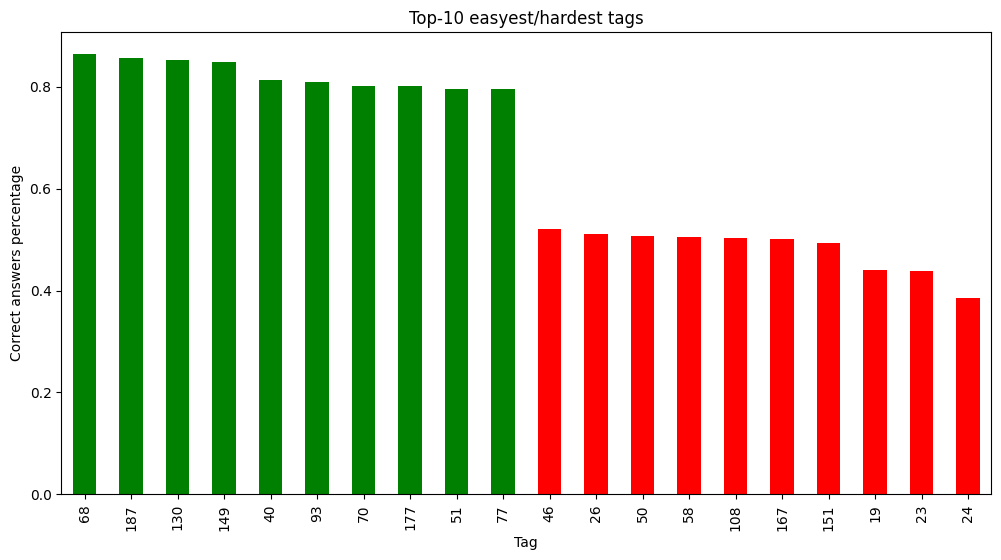

In [25]:
select_rows: List[int] = list(range(0,10)) + list(range(178, len(tags_df)))
tags_select: pd.DataFrame = tags_df.iloc[select_rows,4]
x: List[int] = tags_select.index
y: List[float] = tags_select.values

fig = plt.figure(figsize=(12,6))
clrs = ['red' if y < 0.6 else 'green' for y in tags_select.values]
tags_select.plot.bar(x, y, color=clrs)
plt.title("Top-10 easyest/hardest tags")
plt.xlabel("Tag")
plt.ylabel("Correct answers percentage")
plt.xticks(rotation=90)
plt.show()

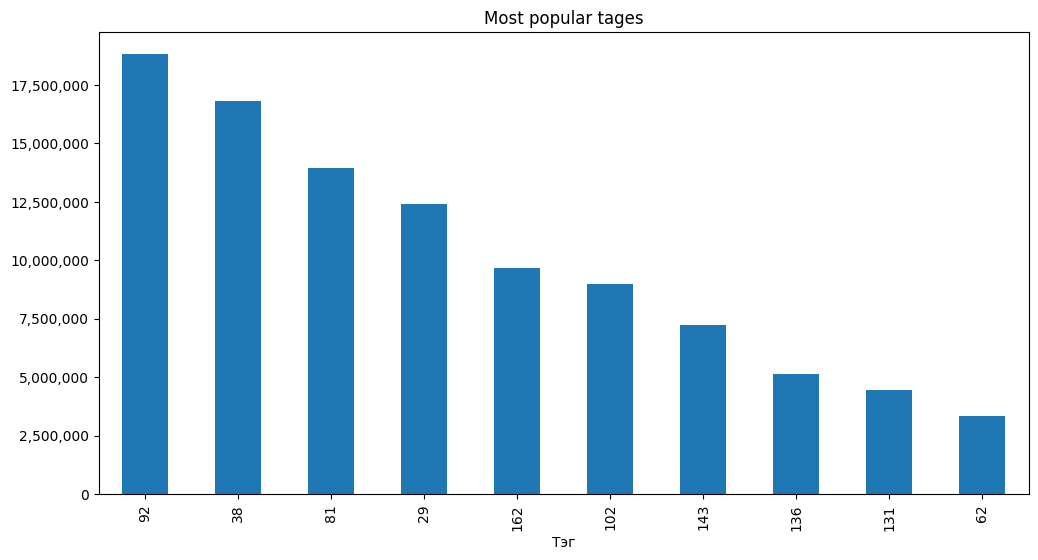

In [26]:
tags_select = tags_df.sort_values(by = "Total_questions", ascending = False).iloc[:10,:]
tags_select = tags_select["Total_questions"]

fig = plt.figure(figsize=(12,6))
ax = tags_select.plot.bar()
plt.title("Most popular tages")
plt.xticks(rotation=90)
plt.xlabel('Тэг')
plt.ticklabel_format(style='plain', axis='y')
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ','))) #add thousands separator
plt.show()

In [27]:
train = train.merge(questions[['question_id','part']], left_on='content_id', right_on='question_id').drop(columns=['question_id'])
train

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,ts_bin,part
0,0,0,115,5692,False,1,3,1,NaN,<NA>,Group_1,5
1,2385,4216576228,24418,5692,False,497,3,1,21000.0,True,Group_6,5
2,8954,0,51285,5692,False,0,3,1,NaN,<NA>,Group_1,5
3,9280,330907575,91216,5692,False,153,3,1,22000.0,True,Group_3,5
4,13269,560202977,138650,5692,False,122,3,1,18000.0,True,Group_3,5
...,...,...,...,...,...,...,...,...,...,...,...,...
100038520,89256667,7327293505,1896513376,5823,False,4239,0,1,21000.0,True,Group_7,5
100038521,97579050,4339553896,2070144393,10008,False,1406,3,1,23750.0,False,Group_6,6
100038522,97579051,4339553896,2070144393,10007,False,1406,1,0,23750.0,False,Group_6,6
100038523,97579052,4339553896,2070144393,10006,False,1406,0,1,23750.0,False,Group_6,6


##### Распределение корректных ответов по частям теста

In [28]:
train.groupby('part')['answered_correctly'].mean().sort_values(ascending=False)

part
1    0.722198
2    0.701912
3    0.686321
6    0.654881
7    0.651956
4    0.609149
5    0.598691
Name: answered_correctly, dtype: float64

### Анализ лекций

In [29]:
print(f"Unique lectures {lectures.shape[0]}")

Unique lectures 418


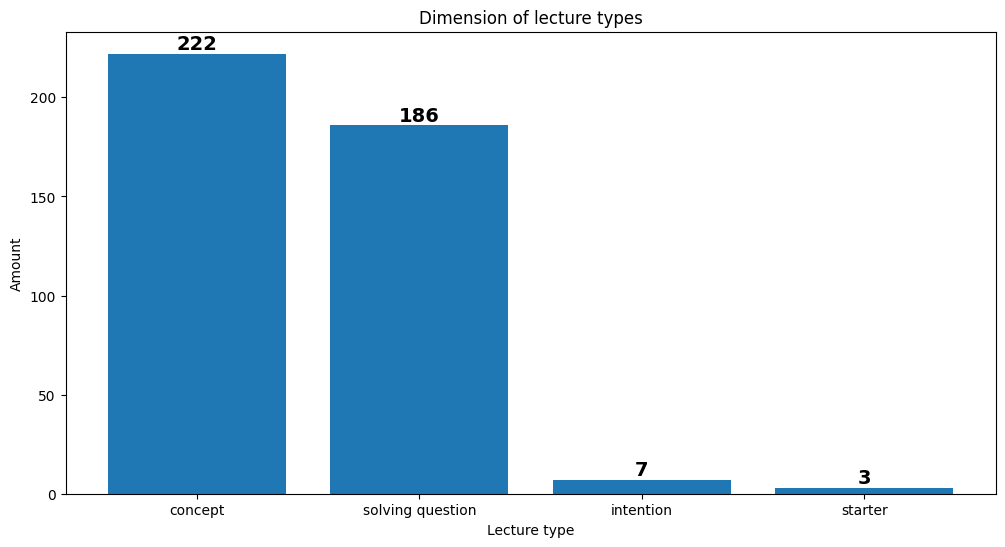

In [30]:
lect_type_of: pd.DataFrame = lectures.type_of.value_counts()

fig = plt.figure(figsize=(12,6))
plt.bar(lect_type_of.index, lect_type_of.values)
for i, v in zip(lect_type_of.index, lect_type_of.values):
    plt.text(i, v, v, color='black', fontweight='bold', fontsize=14, va='bottom', ha='center')
plt.title("Dimension of lecture types")
plt.xlabel("Lecture type")
plt.ylabel("Amount")
plt.xticks(rotation=0)
plt.show()

#### Зависимость количества корректных ответов от типа лекции

False    276095
True     117561
Name: Watches_lecture, dtype: int64


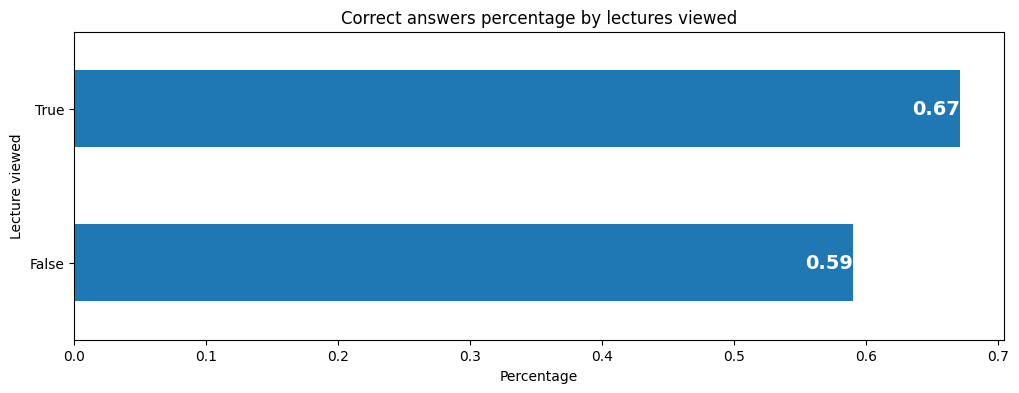

In [31]:
user_lect: pd.DataFrame = train.groupby(["user_id", "answered_correctly"]).size().unstack()
user_lect.columns = ['Lecture', 'Wrong', 'Right']
user_lect['Lecture'] = user_lect['Lecture'].fillna(0)
user_lect = user_lect.astype('Int64')
user_lect['Watches_lecture'] = np.where(user_lect.Lecture > 0, True, False)

watches_l: pd.DataFrame = user_lect.groupby("Watches_lecture").agg({'Wrong': ['sum'], 'Right': ['sum']})
print(user_lect.Watches_lecture.value_counts())

watches_l['Percent_correct'] = watches_l.Right/(watches_l.Right + watches_l.Wrong)

watches_l = watches_l.iloc[:,2]

fig = plt.figure(figsize=(12,4))
watches_l.plot.barh()
for i, v in zip(watches_l.index, watches_l.values):
    plt.text(v, i, round(v,2), color='white', fontweight='bold', fontsize=14, ha='right', va='center')

plt.title("Correct answers percentage by lectures viewed")
plt.xlabel("Percentage")
plt.ylabel("Lecture viewed")
plt.xticks(rotation=0)
plt.show()

In [32]:
batch_lect: pd.DataFrame = train.groupby(["task_container_id", "answered_correctly"]).size().unstack()
batch_lect.columns = ['Lecture', 'Wrong', 'Right']
batch_lect['Lecture'] = batch_lect['Lecture'].fillna(0)
batch_lect = batch_lect.astype('Int64')
batch_lect['Percent_correct'] = batch_lect.Right/(batch_lect.Wrong + batch_lect.Right)
batch_lect['Percent_lecture'] = batch_lect.Lecture/(batch_lect.Lecture + batch_lect.Wrong + batch_lect.Right)
batch_lect = batch_lect.sort_values(by = "Percent_lecture", ascending = False)

print(f"Most viewed: {batch_lect.Lecture[0]}.")

Most viewed: 35.


In [33]:
print(f"Most popular lecture: {batch_lect.iloc[0][0]}.")

Most popular lecture: 4.0.
